## 0. 实验介绍

基于**LSTM**模型预测未来一个交易日的涨跌。

## 1. 数据预处理
### 1.1 根据股票代码划分数据
* 训练集

In [ ]:
cols = [0,1,2,3,4,5,6,7,12]

In [1]:
import pandas as pd

df = pd.read_csv("./data/train.csv", usecols=cols)
stocks_code = df["kdcode"].unique()
stock_num = len(stocks_code)

print(stocks_code)
stock_num

['000001.SZ' '000157.SZ' '000333.SZ' '000568.SZ' '000703.SZ' '000768.SZ'
 '002024.SZ' '002044.SZ' '002049.SZ' '002120.SZ' '002230.SZ' '002271.SZ'
 '002311.SZ' '002371.SZ' '002456.SZ' '002602.SZ' '002607.SZ' '002714.SZ'
 '002773.SZ' '300003.SZ' '300033.SZ' '300124.SZ' '300144.SZ' '300628.SZ'
 '600000.SH' '600009.SH' '600016.SH' '600019.SH' '600025.SH' '600028.SH'
 '600030.SH' '600031.SH' '600036.SH' '600048.SH' '600050.SH' '600061.SH'
 '600104.SH' '600115.SH' '600196.SH' '600276.SH' '600309.SH' '600340.SH'
 '600383.SH' '600489.SH' '600519.SH' '600547.SH' '600570.SH' '600585.SH'
 '600588.SH' '600690.SH' '600703.SH' '600745.SH' '600809.SH' '600837.SH'
 '600848.SH' '600886.SH' '600887.SH' '600926.SH' '600958.SH' '601006.SH'
 '601088.SH' '601166.SH' '601169.SH' '601238.SH' '601318.SH' '601319.SH'
 '601336.SH' '601398.SH' '601555.SH' '601601.SH' '601628.SH' '601788.SH'
 '601838.SH' '601857.SH' '601872.SH' '601899.SH' '601919.SH' '601990.SH'
 '601998.SH' '603233.SH' '603799.SH' '603833.SH']


82

In [2]:
# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code):
    stock_i_data = df[df['kdcode'].isin([stock_i])]
    exec("train_df%s = stock_i_data"%i)

* 测试集

In [3]:
df2 = pd.read_csv("./data/test.csv", usecols=cols)
stocks_code2 = df2["kdcode"].unique()

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code2):
    stock_i_data = df2[df2['kdcode'].isin([stock_i])]
    exec("test_df%s = stock_i_data" % i)

共82支股票

训练集按股票分为`train_df0`~`train_df81`

测试集按股票分为`test_df0`~`test_df81`

### 1.2 将原始数据改造为LSTM网络的输入

In [4]:
feanum=6 # 一共有多少特征
window=10 # 时间窗设置

分割出window个时间窗的数据为输入的`X`

紧接着的那条数据为标签`Y`

因此需要将每只股票的数据按照时间(日期)分割成`window + 1`长度的数据

In [5]:
import numpy as np

trainResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("trainData = train_df%s.values" % i)
    sequence_length = window + 1
    trainData = trainData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(trainData) - sequence_length + 1):
        trainResult.append(trainData[index: index + sequence_length])

trainResult = np.array(trainResult)
trainResult.shape

(73741, 11, 5)

In [6]:
testResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    testData = testData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(testData) - sequence_length + 1):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

(19085, 11, 5)

分割`X`, `Y`

In [7]:
X_train = trainResult[:, :-1, :-1]
X_test = testResult[:, :-1, :-1]

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

print("训练集X：" + str(X_train.shape))
print("测试集X：" + str(X_test.shape))

# X_train[0: 5]

训练集X：(73741, 10, 4)
测试集X：(19085, 10, 4)


处理数据的Y

涨为`1`,跌为`0`

In [8]:
Y_train = trainResult[:, window, -1]
Y_train.shape

(73741,)

In [9]:
Y_test = testResult[:, window, -1]
Y_test.shape

(19085,)

In [10]:
Y_train = Y_train.astype('float64')
Y_test = Y_test.astype('float64')
# Y_train[0:5]
# Y_test[0:5]

## 2. 模型构建与训练

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.callbacks import EarlyStopping

#建立、训练模型过程
d = 0.001
model = Sequential()#建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=False, activation = "relu"))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层

# model.add(LSTM(16, input_shape=(window, feanum), return_sequences=False, activation = "relu"))#建立LSTM层
# model.add(Dropout(d))#建立的遗忘层

model.add(Dense(16,kernel_initializer='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# 使用Early stop
# callbacks_list = [EarlyStopping(monitor='loss', patience=10)] #用early stopping 来防止过拟合
# model.fit(X_train, Y_train, epochs = 150, batch_size = 256, callbacks=callbacks_list) #训练模型epochs次
history = model.fit(X_train, Y_train, epochs = 150, batch_size = 256) #训练模型epochs次

Epoch 1/150
289/289 [==============================] - 3s 9ms/step - loss: 0.6930 - accuracy: 0.5099
Epoch 2/150
289/289 [==============================] - 3s 9ms/step - loss: 0.6929 - accuracy: 0.5106
Epoch 3/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5106
Epoch 4/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6929 - accuracy: 0.5106
Epoch 5/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6928 - accuracy: 0.5106
Epoch 6/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6926 - accuracy: 0.5105
Epoch 7/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6926 - accuracy: 0.5128
Epoch 8/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6925 - accuracy: 0.5123
Epoch 9/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6924 - accuracy: 0.5144
Epoch 10/150
289/289 [==============================] - 2s 8ms/step - loss: 0.6923 - accura

In [12]:
#总结模型
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17664     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 18,721
Trainable params: 18,721
Non-trainable params: 0
_________________________________________________________________


## 3. 模型训练结果
* 训练集

In [13]:
#在训练集上的拟合结果
Y_train_predict=model.predict(X_train)[:,0]
Y_train = Y_train

Text(0.5, 1.0, 'Train Data')

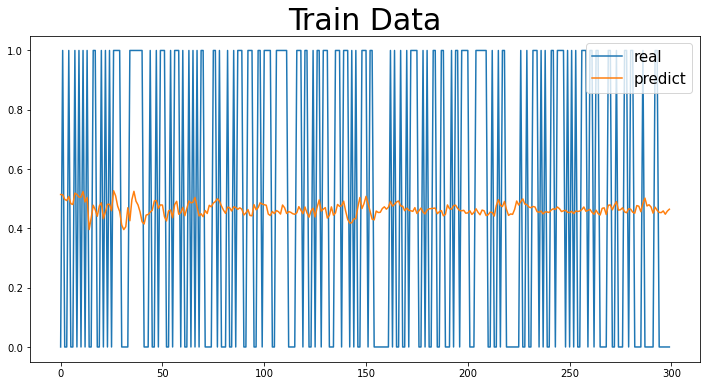

In [14]:
import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_predict)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

* 测试集

In [15]:
#在测试集上的预测
Y_test_predict=model.predict(X_test)[:,0]
Y_test=Y_test

Text(0.5, 1.0, 'Test Data')

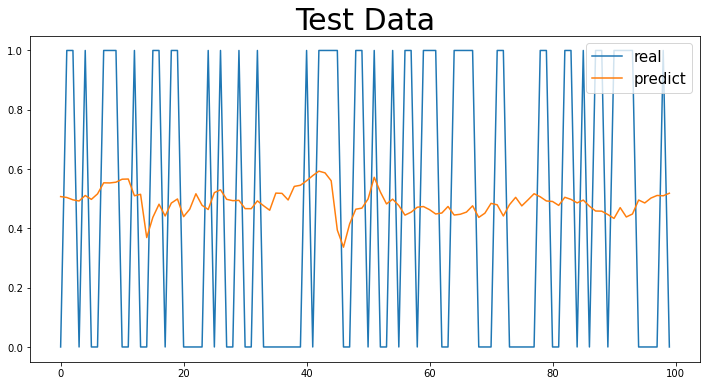

In [16]:
draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_predict)],axis=1);
draw.iloc[:100,0].plot(figsize=(12,6))
draw.iloc[:100,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
# 展示在测试集上的表现 

In [17]:
txt = np.zeros(len(Y_test))
Y_test_predict[Y_test_predict > 0.5] = 1
Y_test_predict[Y_test_predict <= 0.5] = 0
for i in range(len(Y_test)):
    txt[i] = Y_test[i] == Y_test_predict[i]

result=sum(txt) / len(txt)
print('预测涨跌正确:',result)

预测涨跌正确: 0.5305213518470002


* 训练过程Loss,Accuracy的变化

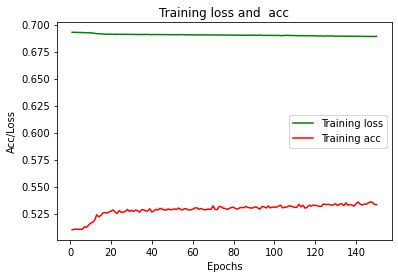

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')  # bo for blue dot 蓝色点
plt.plot(epochs, acc, 'r', label='Training acc')  # bo for blue dot 蓝色点
plt.title('Training loss and  acc')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()

## 4. 分析模型

## 4.1 分析模型在各股票的预测准确率

In [36]:
AnalyData = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    testData = testData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(testData) - sequence_length + 1):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

,kdcode,dt,price_mean5,price_mean10,price_mean20,pct_mean5,label
0,000001.SZ,2020-01-02,0.007478,0.007507,0.007361,0.198148,1.0
1,000001.SZ,2020-01-03,0.007545,0.007550,0.007413,0.201087,1.0
2,000001.SZ,2020-01-06,0.007584,0.007582,0.007456,0.195127,0.0
3,000001.SZ,2020-01-07,0.007650,0.007616,0.007494,0.198194,1.0
4,000001.SZ,2020-01-08,0.007677,0.007628,0.007525,0.190307,0.0
...,...,...,...,...,...,...,...
238,000001.SZ,2020-12-25,0.008300,0.008513,0.008843,0.178923,0.0
239,000001.SZ,2020-12-28,0.008337,0.008498,0.008756,0.197138,1.0
240,000001.SZ,2020-12-29,0.008442,0.008535,0.008718,0.211104,1.0
241,000001.SZ,2020-12-30,0.008546,0.008545,0.008695,0.209616,1.0


## 5. 实验记录

单层 epoch150 window=10
* 测试属性：
  * [2,3,4,5]: 0.5297353942887084
  * [2,3,4,5,6,7,8,9,10,11]: 0.5280586848310191
  * [2,5,8,11]: 0.5213518470002619
  * [2,5,8]: 0.5226617762640817
  * [2,3,4,5,6,7]: 